# Convert from AiGIS format to GeoTIFF format

- Input: AiGIS text file, and associated Polygon ID map
- Output: GeoTIFF format map

In [1]:
import astropy.io.fits as fits
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.transform import from_origin


In [2]:
#AiGIS format files
potentialfile='data/Gravitational_Potential.txt'
slopefile='data/Gravitational_Slope.txt'

In [3]:
# Information about the potential file
index=['Shape model:', 'Label:', 'Unit:', 'Total polygon number:']
with open(potentialfile, 'r') as file:
    for _ in range(4):
        print(index[_], file.readline().strip())

Shape model: #SHAPE_SPC_49k_v20200323.obj.dat_result.txt
Label: Gravitational_Potential
Unit: J/kg
Total polygon number: 49152


In [4]:
#Polygon ID map (SPC-based shape model version 20200323)
plidfile='data/plidmap_SHAPE_SPC_49k_v20200323.fit'

#Load files
plidmap=fits.open(plidfile)[0].data
potential=np.loadtxt(potentialfile,skiprows=4)
slope=np.loadtxt(slopefile,skiprows=4)

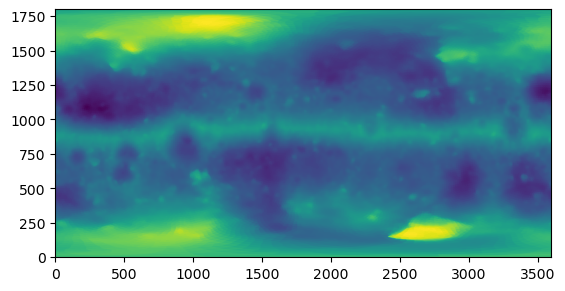

In [5]:
# Create a mapping dictionary from potential[:, 0] to potential[:, 1]
mapping = dict(zip(potential[:, 0], potential[:, 1]))

# Replace values in plidmap using the mapping
vectorized_mapping = np.vectorize(mapping.get)
plidmap_replaced = vectorized_mapping(plidmap)

plt.imshow(plidmap_replaced, origin='lower')
plt.show()

In [6]:
# Define the CRS information for Ryugu
custom_crs = """
GEOGCRS["162173 Ryugu (JAXA2024) - Sphere",
DATUM["162173 Ryugu (JAXA2024) - Sphere",
        ELLIPSOID["162173 Ryugu (JAXA2024) - Sphere", 448, 0,
            LENGTHUNIT["metre", 1]]],
    PRIMEM["Prime", 0,
        ANGLEUNIT["degree", 0.0174532925199433]],
CS[ellipsoidal,2],
    AXIS["Planetocentric latitude", north,ORDER[1],
    ANGLEUNIT["degree", 0.0174532925199433]],
    AXIS["Planetocentric longitude", east,ORDER[2],
    ANGLEUNIT["degree", 0.0174532925199433]]]
"""

In [7]:

# Define the transform (example values, adjust as needed)
transform = from_origin(0, -90, 0.1, -0.1)  # top-left corner (0 deg, -90 deg), pixel size 0.1 deg/pix

# Output folder
out_folder = './output/'
# Output file name
output=out_folder+'Gravitational_potential.SPCv20200323.49k.tif'

# Write the GeoTIFF
with rasterio.open(
    output,
    'w',
    driver='GTiff',
    height=plidmap_replaced.shape[0],
    width=plidmap_replaced.shape[1],
    count=1,
    dtype=plidmap_replaced.dtype,
    crs=custom_crs,
    transform=transform,
) as dst:
    dst.write(plidmap_replaced, 1)